In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [ ]:
# run cell for interactive plots
import mpld3
mpld3.enable_notebook()

In [2]:
from reldresal import load_log

In [3]:
from enum import Enum
ExctType = Enum('ExctType', ['upper', 'lower'])
ExctFreq = Enum('ExctFreq', ['f0', 'f1', 'f2'])
import collections
Record = collections.namedtuple('Record', ['exct_type', 'exct_freq', 'data'])

# load data files
records = []
records.append(Record(ExctType.lower, ExctFreq.f0, load_log('t_lower_f0.log.gz')))
records.append(Record(ExctType.lower, ExctFreq.f1, load_log('t_lower_f1.log.gz')))
records.append(Record(ExctType.lower, ExctFreq.f2, load_log('t_lower_f2.log.gz')))
records.append(Record(ExctType.upper, ExctFreq.f0, load_log('t_upper_f0.log.gz')))
records.append(Record(ExctType.upper, ExctFreq.f1, load_log('t_upper_f1.log.gz')))
records.append(Record(ExctType.upper, ExctFreq.f2, load_log('t_upper_f2.log.gz')))

In [4]:
from phobos.constants import sa

# Estimate inertia, damping of other mass by least squares.
# If excitation is applied to upper assembly, this function
# estimates the inertia and damping of the lower assembly.
# This assumes that the difference in position of the upper
# and lower assembly is negligible.
#
# T = m*x_dd + b*x_d
# T = [x_dd, x_d] [m, b]'

savgol_width = 111
savgol_polyorder = 5

def sg_filter(signal, deriv, delta=0):
    x = scipy.signal.savgol_filter(
        signal, savgol_width, savgol_polyorder,
        deriv=deriv, delta=delta,
        mode='nearest').reshape((-1, 1))
    return x

def estimate_mb(record):
    dt = np.mean(np.diff(record.data.time)[:-1])
    torque = convert_adc_nm(record)
    velocity = sg_filter(record.data.steer_angle, 1, dt)
    acceleration = sg_filter(record.data.steer_angle, 2, dt)
    A = np.hstack((acceleration, velocity))
    return np.squeeze(np.linalg.lstsq(A, torque)[0])

def convert_adc_nm(record):
    torque_adc = record.data.kistler_torque_adc
    t_neg_mask = (torque_adc > sa.KISTLER_ADC_ZERO_OFFSET_NEGATIVE).astype(int)
    t_pos_mask = (torque_adc < sa.KISTLER_ADC_ZERO_OFFSET_POSITIVE).astype(int)
    t_neg = (t_neg_mask *
             (sa.MAX_KISTLER_TORQUE_NEGATIVE/sa.ADC_HALF_RANGE) *
             (torque_adc - sa.KISTLER_ADC_ZERO_OFFSET_NEGATIVE))
    t_pos = (t_pos_mask *
             (sa.MAX_KISTLER_TORQUE_POSITIVE/sa.ADC_HALF_RANGE) *
             (torque_adc - sa.KISTLER_ADC_ZERO_OFFSET_POSITIVE))
    torque = t_neg + t_pos
    if record.exct_type == ExctType.upper:
        # need to negate sensor torque reading
        return -torque
    return torque

In [5]:
def plot_estimates(record):
    m, b = estimate_mb(record)
    if record.exct_type == ExctType.lower:
        assembly_type = 'upper'
    else:
        assembly_type = 'lower'
    print('record {}, {}'.format(record.exct_type, record.exct_freq))
    print('{} estimated inertia: {}'.format(assembly_type, m))
    print('{} estimated viscous damping: {}'.format(assembly_type, b))
    
    colors = sns.color_palette('Paired', 10)
    fig, ax = plt.subplots(1, 1, figsize=(11, 6), sharex=True)
    dt = np.mean(np.diff(record.data.time)[:-1])
    torque = convert_adc_nm(record)
    veloc = sg_filter(record.data.steer_angle, 1, dt)
    accel = sg_filter(record.data.steer_angle, 2, dt)
    ax.plot(record.data.time, torque, color=colors[3],
            alpha=0.8,
            label='sensor torque')
    ax.plot(record.data.time, m*accel, color=colors[4],
            alpha=0.8,
            label='inertia torque')
    ax.plot(record.data.time, b*veloc, color=colors[6],
            alpha=0.8,
            label='damping torque')
    ax.plot(record.data.time, m*accel + b*veloc, color=colors[8],
            alpha=0.8,
            label='sum inertia and damping torque')
    ax.legend()
    ax.set_xlabel('time [s]')
    ax.set_ylabel('torque [N-m]')
    ax.plot(record.data.time, 0*record.data.time, color='black', linewidth=1, zorder=1)
    plt.show()

record ExctType.lower, ExctFreq.f0
upper estimated inertia: 0.03342716133788664
upper estimated viscous damping: 0.020177033016919296


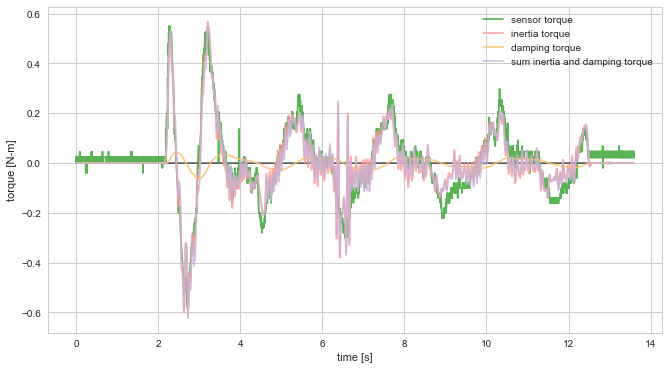

record ExctType.lower, ExctFreq.f1
upper estimated inertia: 0.03294647075099463
upper estimated viscous damping: 0.002137143304095823


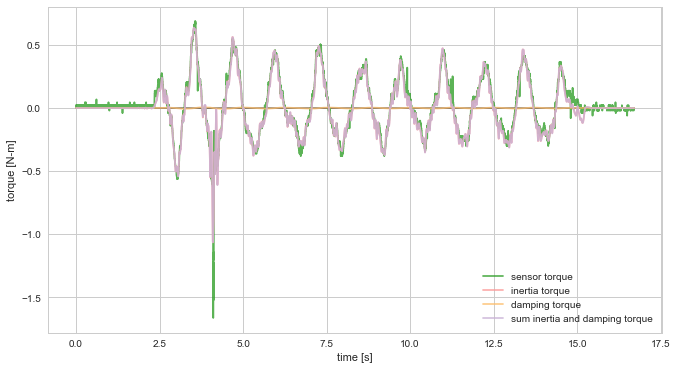

record ExctType.lower, ExctFreq.f2
upper estimated inertia: 0.03164419176107005
upper estimated viscous damping: 0.011803862047518123


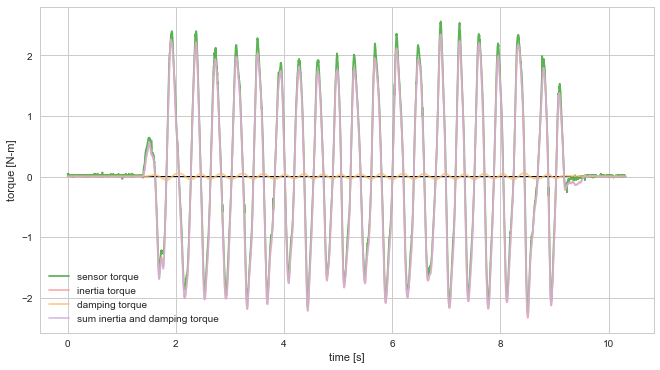

record ExctType.upper, ExctFreq.f0
lower estimated inertia: -0.0035574482735217412
lower estimated viscous damping: 0.09902669577563385


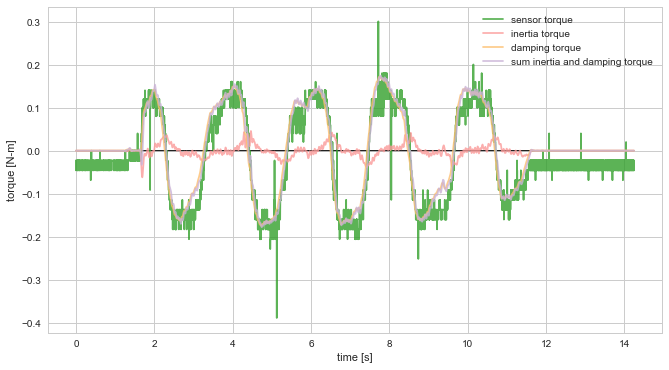

record ExctType.upper, ExctFreq.f1
lower estimated inertia: 0.00040790248530021616
lower estimated viscous damping: 0.06756423749965516


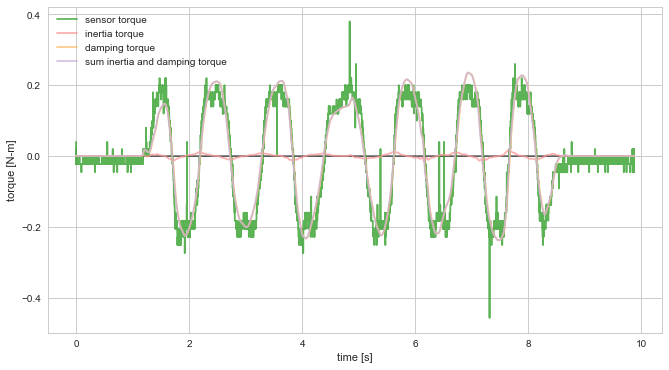

record ExctType.upper, ExctFreq.f2
lower estimated inertia: 0.0022029660872081055
lower estimated viscous damping: 0.03887520062855849


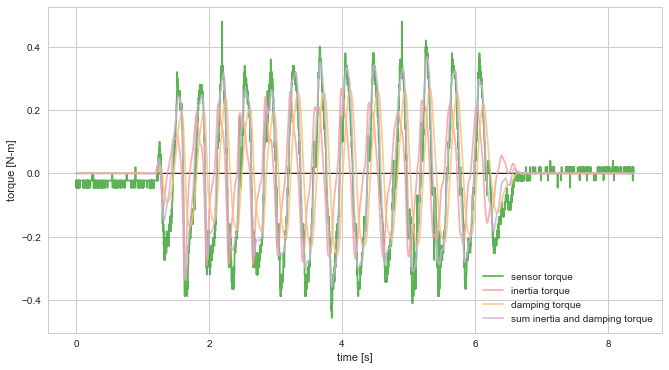

In [6]:
for r in records:
    plot_estimates(r)

In [7]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    import sympy


def kalman_system_matrices(inertia, damping, timestep):
    m, b, dt = sympy.symbols('m b dt')
    # continuous time state matrix
    A = sympy.Matrix([
        [0, 1],
        [0, -b/m]
    ])
    # continuous time input matrix
    B = sympy.Matrix([
        [0],
        [1/m]
    ])
    M = sympy.Matrix.vstack(
            sympy.Matrix.hstack(A, B),
            sympy.Matrix.zeros(1, 3))*dt
    # exp([A B]) = [Ad Bd]
    #     [0 0]    [ 0  I]

    # use Tustin transform to approximate Matrix exponential
    # exp(M) = (I + 1/2*M)*(I - 1/2*M)^-1
    I = sympy.eye(3)
    Md = (I + 1/2*M)*((I - 1/2*M).inv())
    assert Md[2, 2] == 1
    Md.simplify()
    
    subvals = {m: inertia, b: damping, dt: timestep}
    Ad = Md[:2, :2,].subs(subvals)
    Bd = Md[:2, 2:].subs(subvals)
    
    Ad = np.array(Ad).astype(np.float64)
    Bd = np.array(Bd).astype(np.float64)
    Cd = np.array([1, 0]).reshape((1, -1))
    Dd = np.array([0]).reshape((1, 1))
    Q = np.array([
        [1/4*timestep**4, 1/2*timestep**3],
        [1/2*timestep**3, timestep**2]])
    R = np.array([2.03049e-6]).reshape((1, 1))
    return Ad, Bd, Cd, Dd, Q, R

In [8]:
from phobos.kalman import Kalman

def plot_data(record, show_plot=True):
    colors = sns.color_palette('Paired', 10)
    fig, ax = plt.subplots(3, 1, figsize=(11, 6), sharex=True)
    
    steer_angle = record.data.steer_angle
    kistler_torque = convert_adc_nm(record)
    
    ## Kalman parameters the give a good fit
    m = 0.03        # lower assembly inertia
    b = 0.099       # lower assembly damping
    dt = 0.001      # timestep
    q = 100         # process noise covariance coefficient
    A, B, C, D, Q, R = kalman_system_matrices(m, b, dt)
    u = kistler_torque.reshape((-1, 1, 1))
    z = steer_angle.reshape((-1, 1, 1))
    kalman = Kalman(A, B, C, D, q*Q, R)
    x = kalman.estimate_state(u, z)
    steer_rate = x[:, 1]
    
    ax[0].plot(record.data.time, steer_angle,
               color=colors[1], label='steer angle')
    ax[0].plot(record.data.time, 0*record.data.time,
               color='black', linewidth=1, zorder=1)
    ax[0].legend()
    ax[0].set_xlabel('time [s]')
    ax[0].set_ylabel('[rad]')

    ax[1].plot(record.data.time, steer_rate,
               color=colors[5], label='steer rate (kalman estimate)')
    ax[1].plot(record.data.time, sg_filter(steer_angle, 1, dt),
               color=colors[7], label='steer rate (savgol, postprocess)')
    ax[1].plot(record.data.time, 0*record.data.time,
               color='black', linewidth=1, zorder=1)
    ax[1].legend()
    ax[1].set_xlabel('time [s]')
    ax[1].set_ylabel('[rad/s]')

    ax[2].plot(record.data.time, kistler_torque, color=colors[3],
               alpha=0.8, label='sensor torque')
    ax[2].plot(record.data.time, 0*record.data.time, color='black', linewidth=1, zorder=1)
    ax[2].legend()
    ax[2].set_xlabel('time [s]')
    ax[2].set_ylabel('torque [N-m]')
    
    title = 'torque {}, {}'.format(record.exct_type, record.exct_freq)
    try:
        mpld3
    except NameError:
        fig.suptitle(title)
    else:
        ax[0].set_title(title)
    if show_plot:
        plt.show()
    return fig, ax

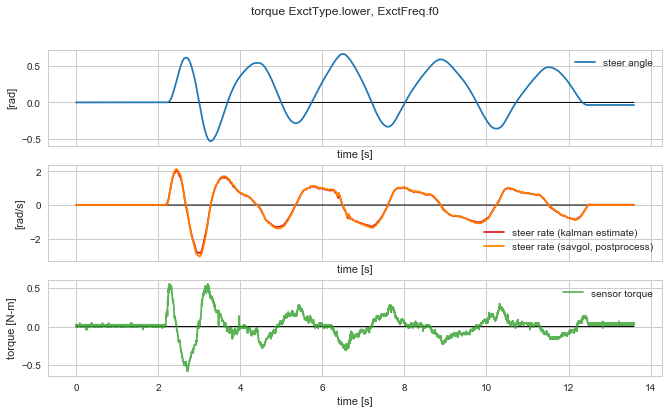

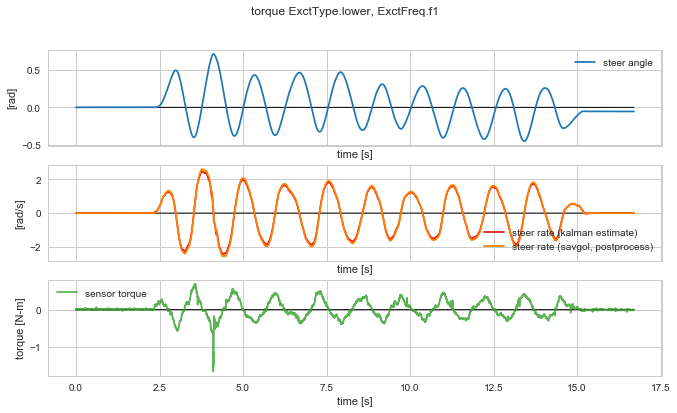

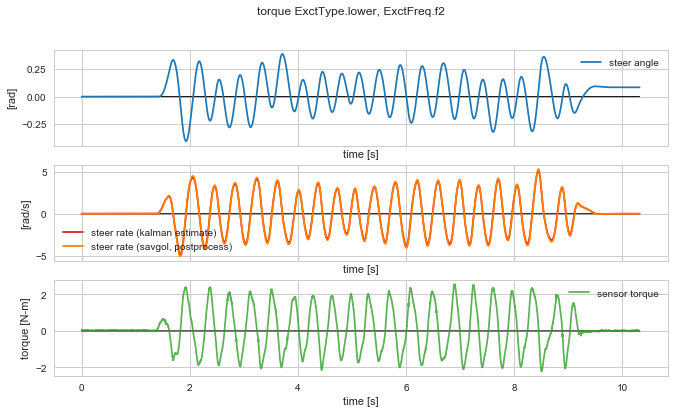

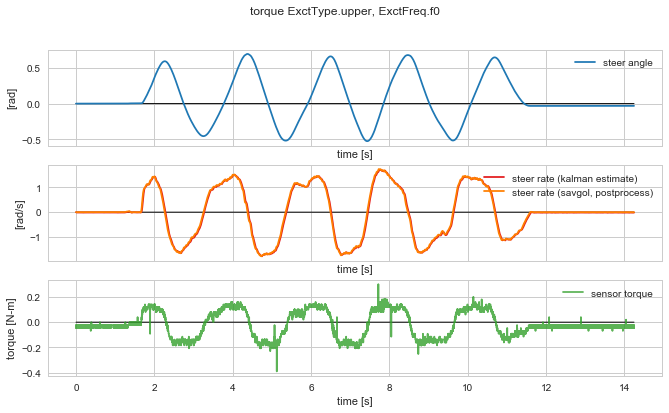

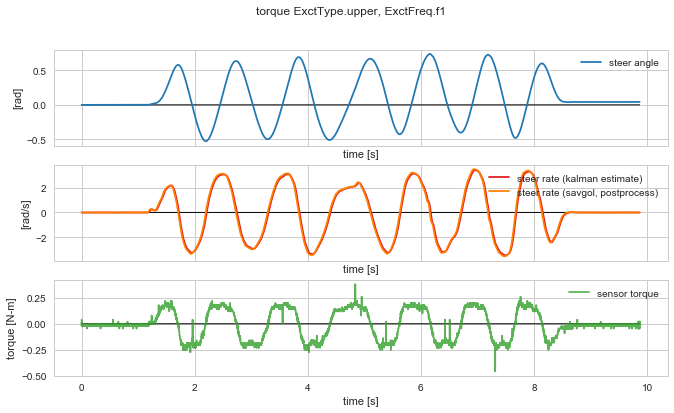

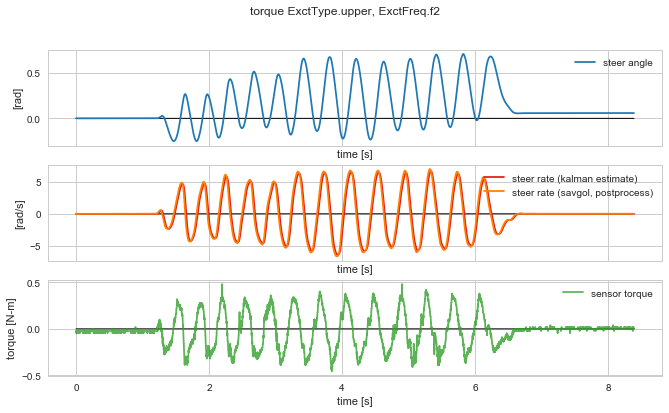

In [9]:
for r in records:
    plot_data(r)